# Evolución del lenguaje 2: Ver cómo ha variado el lenguaje mediante calculando vectores y comprobando qué episodios se parecen más entre sí

Se pretende hacer este estudio, primero con TF-IDF vectorizer (en este cuaderno) y después si hay tiempo comprobarlo con un word embedding (en el siguiente cuaderno), a ver si varía.

## Librerías

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Datos

In [86]:
df_episode = pd.read_csv('The Saimpsons Archive/in_use/simpsons_episodes.csv')

In [87]:
df_script = pd.read_csv('The Saimpsons Archive/in_use/simpsons_script_lines.csv')
df_script.sample(4)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
34727,44551,157,116,"Larry: Hey, Pop, this crowd is pretty swanky. ...",596000,True,353.0,1386.0,Larry,Springfield Glen Country Club,"Hey, Pop, this crowd is pretty swanky. I'm not...",hey pop this crowd is pretty swanky im not gon...,13.0
28444,38164,132,279,MARTIN'S SOUL: (YELP),1298000,False,1782.0,5.0,MARTIN'S SOUL,Simpson Home,NaN,NaN,0.0
3189,12727,42,245,C. Montgomery Burns: (CONSIDERING) I don't kno...,1048000,True,15.0,351.0,C. Montgomery Burns,Cemetery,I don't know. I feel like a kid in a candy store.,i dont know i feel like a kid in a candy store,12.0
120545,130745,465,124,Ethan Foley: Rehearsing my Ibsen.,512000,True,45.0,3772.0,Ethan Foley,EXPRESSIONS- WOODED CLEARING,Rehearsing my Ibsen.,rehearsing my ibsen,3.0


In [88]:
def join_text(text):
    return ' '.join(text)

In [89]:
df_script_agg = df_script[[
    'episode_id',
    'raw_text'
]].groupby('episode_id').agg({'raw_text':join_text})

In [90]:
df = df_script_agg.reset_index()[['episode_id', 'raw_text']]
df = df.reset_index()
df = df.drop('index', axis=1)
df

,episode_id,raw_text
0,1,(Street: ext. street - establishing - night) (...
1,2,Bart Simpson: I'll pay! How much? (Simpson Liv...
2,3,Rod #2: (FROM SCREEN) We're radioactive! Rod #...
3,4,"Bart Simpson: Oh, yeah? Lisa Simpson: Yeah! Ba..."
4,5,Bart Simpson: Here? Marge Simpson: These are f...
...,...,...
559,564,(Simpson Home: ext. simpson house - backyard -...
560,565,Milhouse Van Houten: AND OUR DENTISTS ARE ALL ...
561,566,(Theater: ext. theater - night) Singers: (SING...
562,567,Workman: Forty-three is missing again! (FIVE S...


## Vectorizando con TF-IDF

### Tokenizando y lematizando

In [91]:
### Tokenización
df['tokenized_text'] = df['raw_text'].apply(nltk.word_tokenize)
def filter_alpha(tokens):
    return [x for x in tokens if x.isalpha()]

df['tokenized_text'] = df['tokenized_text'].apply(filter_alpha)

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['lemmatized_text'] = df['tokenized_text'].apply(lemmatize_tokens)

df.head()

,episode_id,raw_text,tokenized_text,lemmatized_text
0,1,(Street: ext. street - establishing - night) (...,"[Street, ext, street, establishing, night, Car...","[Street, ext, street, establishing, night, Car..."
1,2,Bart Simpson: I'll pay! How much? (Simpson Liv...,"[Bart, Simpson, I, pay, How, much, Simpson, Li...","[Bart, Simpson, I, pay, How, much, Simpson, Li..."
2,3,Rod #2: (FROM SCREEN) We're radioactive! Rod #...,"[Rod, FROM, SCREEN, We, radioactive, Rod, FROM...","[Rod, FROM, SCREEN, We, radioactive, Rod, FROM..."
3,4,"Bart Simpson: Oh, yeah? Lisa Simpson: Yeah! Ba...","[Bart, Simpson, Oh, yeah, Lisa, Simpson, Yeah,...","[Bart, Simpson, Oh, yeah, Lisa, Simpson, Yeah,..."
4,5,Bart Simpson: Here? Marge Simpson: These are f...,"[Bart, Simpson, Here, Marge, Simpson, These, a...","[Bart, Simpson, Here, Marge, Simpson, These, a..."


### Aplicando TF-IDF al dataframe

In [92]:
df['corpus'] = df['lemmatized_text'].apply(' '.join)

# TfidfVectorizer:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=200, max_df=0.8)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['corpus'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
result_df =pd.concat([df[['episode_id']], tfidf_df], axis=1)

# Check:
print(result_df.shape, result_df.dtypes)
result_df.head()

(564, 328) episode_id      int64
accent        float64
actually      float64
afraid        float64
afternoon     float64
               ...   
wow           float64
wrong         float64
ya            float64
yard          float64
young         float64
Length: 328, dtype: object


,episode_id,accent,actually,afraid,afternoon,ah,ai,air,angry,announcer,...,woo,word,world,worried,worry,wow,wrong,ya,yard,young
0,1,0.0,0.000000,0.000000,0.000000,0.108221,0.027046,0.0,0.000000,0.208150,...,0.000000,0.046143,0.000000,0.0,0.044040,0.020531,0.000000,0.020265,0.000000,0.024007
1,2,0.0,0.000000,0.000000,0.024593,0.000000,0.023790,0.0,0.020948,0.000000,...,0.000000,0.101469,0.000000,0.0,0.058107,0.036118,0.038813,0.017825,0.000000,0.042234
2,3,0.0,0.018691,0.000000,0.021462,0.083072,0.000000,0.0,0.000000,0.039945,...,0.042924,0.035420,0.015186,0.0,0.033806,0.031519,0.000000,0.000000,0.000000,0.055285
3,4,0.0,0.030166,0.000000,0.051958,0.013407,0.000000,0.0,0.014752,0.080586,...,0.000000,0.028583,0.012255,0.0,0.027281,0.012718,0.013667,0.000000,0.056370,0.000000
4,5,0.0,0.015944,0.016894,0.018308,0.014173,0.017711,0.0,0.000000,0.000000,...,0.000000,0.015108,0.025909,0.0,0.014419,0.013444,0.014447,0.026540,0.079453,0.062883


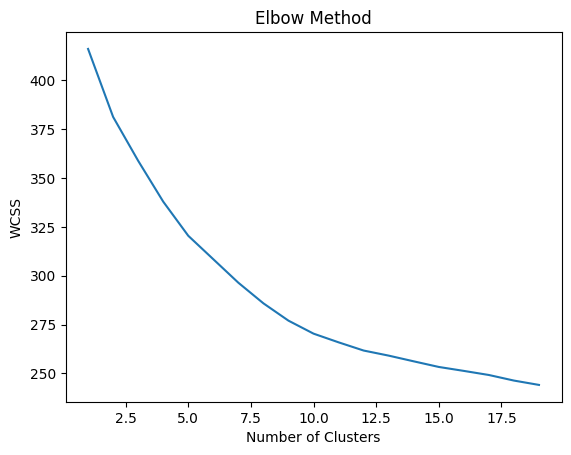

In [93]:
# Initialize list to store WCSS values
wcss = []

# Fit K-Means for a range of cluster numbers
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(result_df.drop(['episode_id'], axis=1))
    wcss.append(kmeans.inertia_)  # inertia_ contains the WCSS value

# Plot WCSS vs. number of clusters
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### Aplicando PCA

In [94]:
result_df.sample()

,episode_id,accent,actually,afraid,afternoon,ah,ai,air,angry,announcer,...,woo,word,world,worried,worry,wow,wrong,ya,yard,young
6,7,0.0,0.0,0.145617,0.0,0.061081,0.0,0.0,0.0,0.073427,...,0.0,0.065109,0.055829,0.06775,0.155356,0.02897,0.031131,0.028594,0.085604,0.033875


In [95]:
column_to_index = 'episode_id'
df_pca = result_df.set_index(column_to_index)
df_pca.sample()

,accent,actually,afraid,afternoon,ah,ai,air,angry,announcer,annoyed,...,woo,word,world,worried,worry,wow,wrong,ya,yard,young
episode_id,,,,,,,,,,,,,,,,,,,,,
372,0.0,0.0,0.0,0.017427,0.0,0.016858,0.0,0.0,0.194612,0.011844,...,0.017427,0.014381,0.012331,0.014964,0.0,0.0,0.0,0.050525,0.018907,0.014964


In [96]:
pca = PCA(n_components=0.34)
df_pca_components = pca.fit_transform(df_pca)
df_pca_result = pd.DataFrame(df_pca_components, columns=[f'PC_{i+1}' for i in range(df_pca_components.shape[1])])

# df_pca_result[column_to_exclude] = result_df[column_to_exclude]
# df_pca_result.set_index(column_to_exclude, inplace=True)
df_pca_result.shape, df_pca_result.head()

((564, 5),
        PC_1      PC_2      PC_3      PC_4      PC_5
 0  0.004562  0.185450  0.135315 -0.053949  0.013120
 1 -0.304336 -0.395290  0.275964 -0.007877 -0.309654
 2  0.530712 -0.068298 -0.041663 -0.135296 -0.047742
 3  0.466774 -0.043978 -0.007469 -0.022029  0.011926
 4 -0.191570 -0.204696  0.108909  0.023457  0.114232)

In [97]:
df_pca_result = df_pca_result.reset_index().rename(columns={'index':'episode_id'}).set_index('episode_id')
df_pca_result.sample()

,PC_1,PC_2,PC_3,PC_4,PC_5
episode_id,,,,,
439,-0.096313,-0.017091,-0.112565,0.024614,0.155352


### Aplicando el clustering K-means

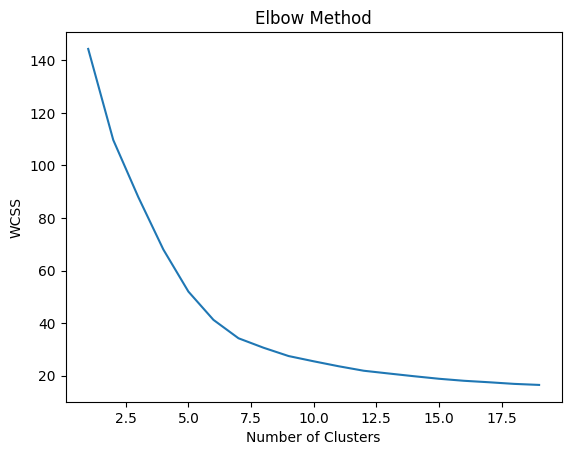

In [98]:
# Initialize list to store WCSS values
wcss = []

# Fit K-Means for a range of cluster numbers
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    kmeans.fit(df_pca_result)
    wcss.append(kmeans.inertia_)  # inertia_ contains the WCSS value

# Plot WCSS vs. number of clusters
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

En principio, el codo estaría alrededor de 5 o 6.

In [99]:
n = 5

kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_pca_result)

cluster_labels = kmeans.labels_
df_pca_result['Cluster'] = cluster_labels

df_pca_result.reset_index(inplace=True)

### Visualizando Clusters a lo largo de las temporadas y episodios

In [100]:
result_df2 = df_pca_result[['episode_id', 'Cluster']]
result_df2 = pd.merge(result_df2, df_episode[['id', 'season', 'number_in_season']], left_on='episode_id', right_on='id')

In [101]:
#Create a pivot table with episodes and ratigns
ep_piv = result_df2.pivot_table(index='season', columns='number_in_season', values='Cluster')
ep_piv.head()

number_in_season,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
season,,,,,,,,,,,,,,,,,,,,,
1,2.0,3.0,3.0,2.0,1.0,0.0,1.0,1.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,1.0,3.0,3.0,0.0,1.0,1.0,4.0,3.0,1.0,...,1.0,3.0,2.0,1.0,2.0,3.0,1.0,NaN,NaN,NaN
3,1.0,0.0,2.0,3.0,4.0,3.0,1.0,1.0,1.0,3.0,...,3.0,2.0,3.0,1.0,4.0,2.0,2.0,3.0,4.0,NaN
4,0.0,0.0,4.0,3.0,1.0,3.0,1.0,1.0,0.0,1.0,...,3.0,3.0,4.0,2.0,0.0,4.0,1.0,NaN,NaN,NaN
5,1.0,3.0,3.0,3.0,1.0,1.0,0.0,3.0,3.0,1.0,...,1.0,3.0,2.0,2.0,3.0,1.0,0.0,NaN,NaN,NaN


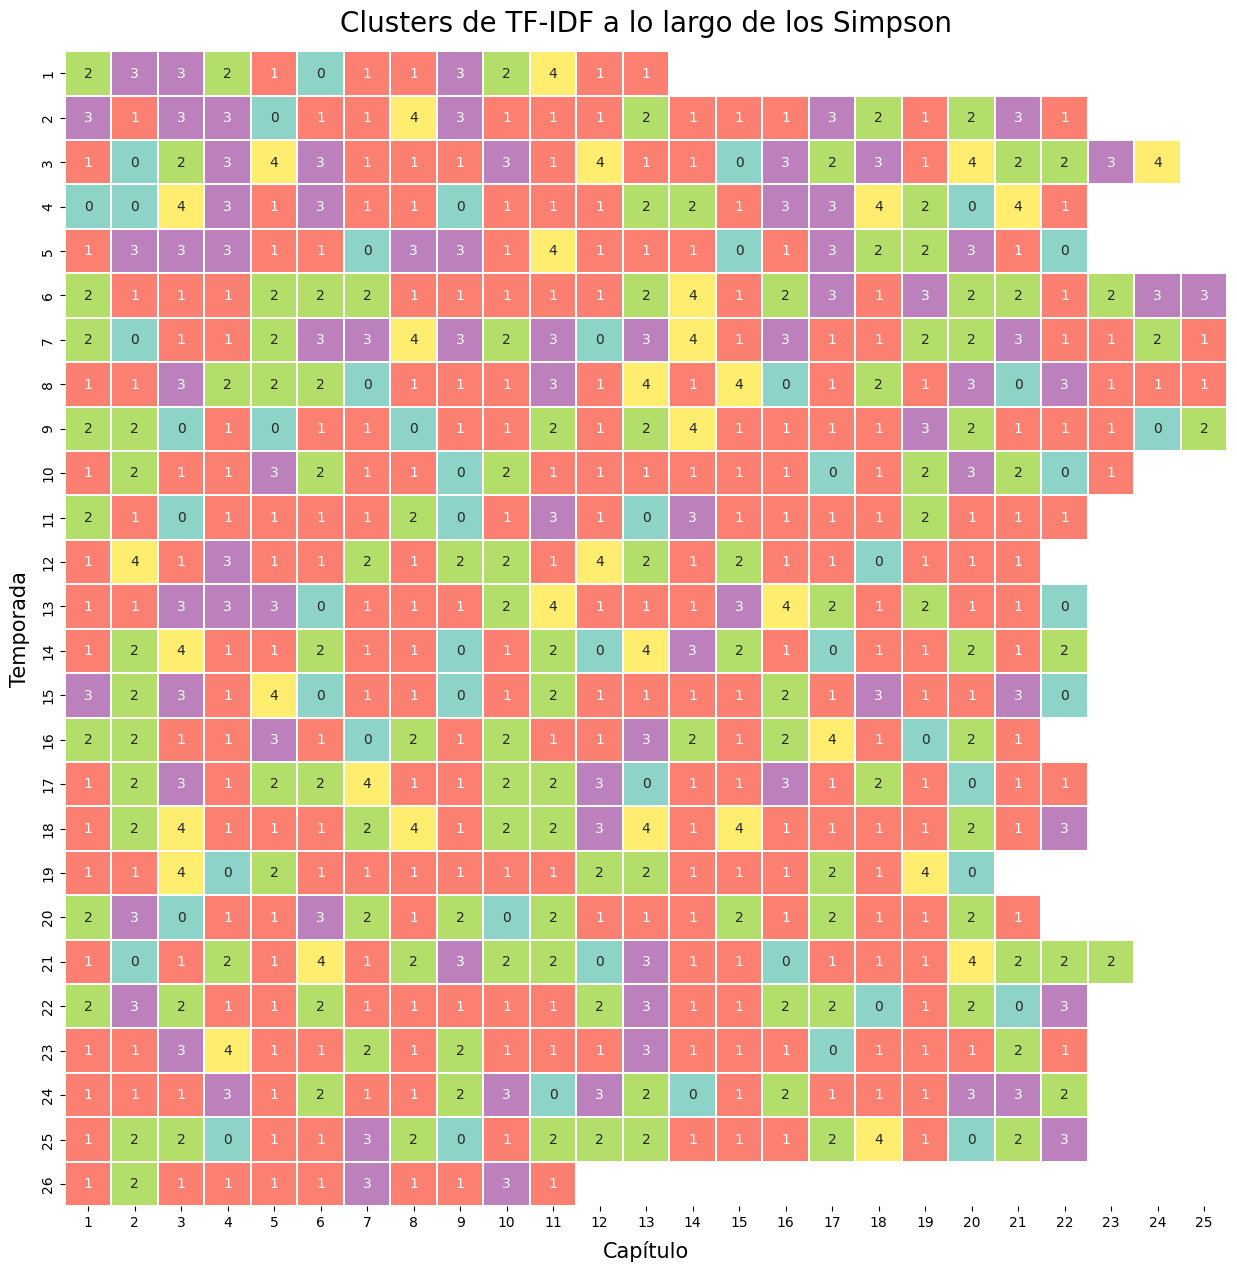

In [102]:
#Heatmap visualization
plt.figure(figsize=(15,15))
sns.heatmap(ep_piv, cmap='Set3', annot=True, linewidths=0.2,cbar_kws={'label': 'Cluster'}, cbar=False)
plt.xlabel('Capítulo', fontsize=15, labelpad=8)
plt.ylabel('Temporada', fontsize=15, labelpad=8)
plt.title('Clusters de TF-IDF a lo largo de los Simpson', fontsize=20, pad=14)
plt.show()

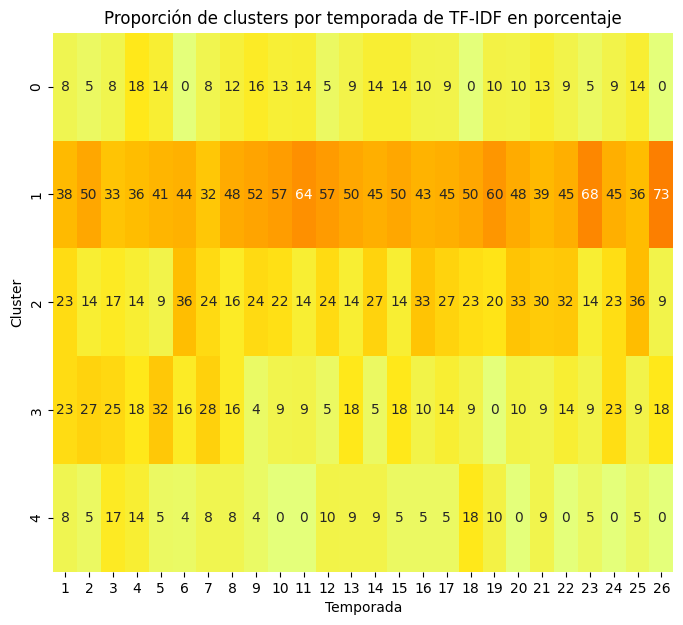

In [103]:
confusion_matrix = pd.crosstab(index=result_df2['Cluster'], columns=result_df2['season'])
row_sums = confusion_matrix.sum(axis=0)
confusion_matrix_relative = confusion_matrix.div(row_sums, axis=1) * 100

plt.figure(figsize=(8, 7))
sns.heatmap(confusion_matrix_relative, annot=True, cmap='Wistia', fmt='.0f', cbar=False)
plt.xlabel('Temporada')
plt.ylabel('Cluster')
plt.title('Proporción de clusters por temporada de TF-IDF en porcentaje')
plt.show()

In [104]:
season_group_1 = range(1,11)
season_group_2 = range(11, 20)
season_group_3 = range(20, 29)

result_df2.loc[result_df2['season'].isin(season_group_1), 'season_group'] = 1
result_df2.loc[result_df2['season'].isin(season_group_2), 'season_group'] = 2
result_df2.loc[result_df2['season'].isin(season_group_3), 'season_group'] = 3
result_df2.sample(5)

,episode_id,Cluster,id,season,number_in_season,season_group
147,148,2,148,7,20,1.0
111,112,1,112,6,9,1.0
505,506,1,506,23,20,3.0
294,295,1,295,14,4,2.0
52,53,3,53,3,18,1.0


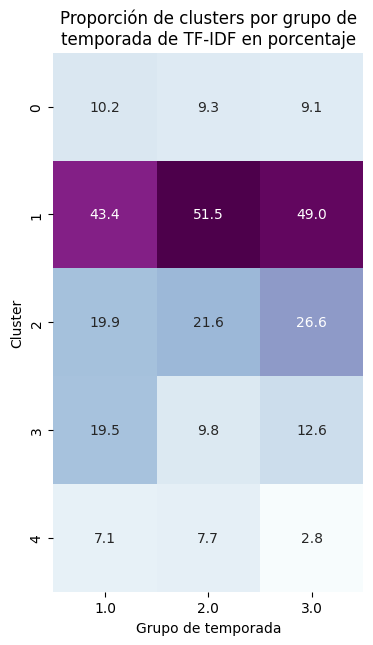

In [105]:
confusion_matrix = pd.crosstab(index=result_df2['Cluster'], columns=result_df2['season_group']) # Confussion matrix with absolute numbers
row_sums = confusion_matrix.sum(axis=0)
confusion_matrix_relative = confusion_matrix.div(row_sums, axis=1) * 100  # Multiply by 100 to get percentages, confussion matrix with relative numbers

plt.figure(figsize=(4, 7))
sns.heatmap(confusion_matrix_relative, annot=True, cmap='BuPu', fmt='.1f', cbar=False)  # fmt='.1f' for one decimal place
plt.xlabel('Grupo de temporada')
plt.ylabel('Cluster')
plt.title('Proporción de clusters por grupo de\ntemporada de TF-IDF en porcentaje')

plt.show()


# Representación 3D

In [166]:
df_pca.shape, df_pca.sample()

((564, 327),
              accent  actually  afraid  afternoon        ah   ai  air  angry  \
 episode_id                                                                    
 273         0.00888  0.007232     0.0        0.0  0.057855  0.0  0.0    0.0   
 
             announcer   annoyed  ...  woo  word  world  worried    worry  \
 episode_id                       ...                                       
 273               0.0  0.005643  ...  0.0   0.0    0.0      0.0  0.00654   
 
                  wow  wrong   ya  yard     young  
 episode_id                                        
 273         0.030489    0.0  0.0   0.0  0.057042  
 
 [1 rows x 327 columns])

In [167]:
df_pca_result.shape, df_pca_result.sample()

((564, 7),
      episode_id      PC_1      PC_2      PC_3      PC_4      PC_5  Cluster
 432         432 -0.031507  0.134907 -0.159078  0.018406  0.033275        1)

In [168]:
y_pred = df_pca_result['Cluster']
X_3d = df_pca

In [169]:
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_3d)

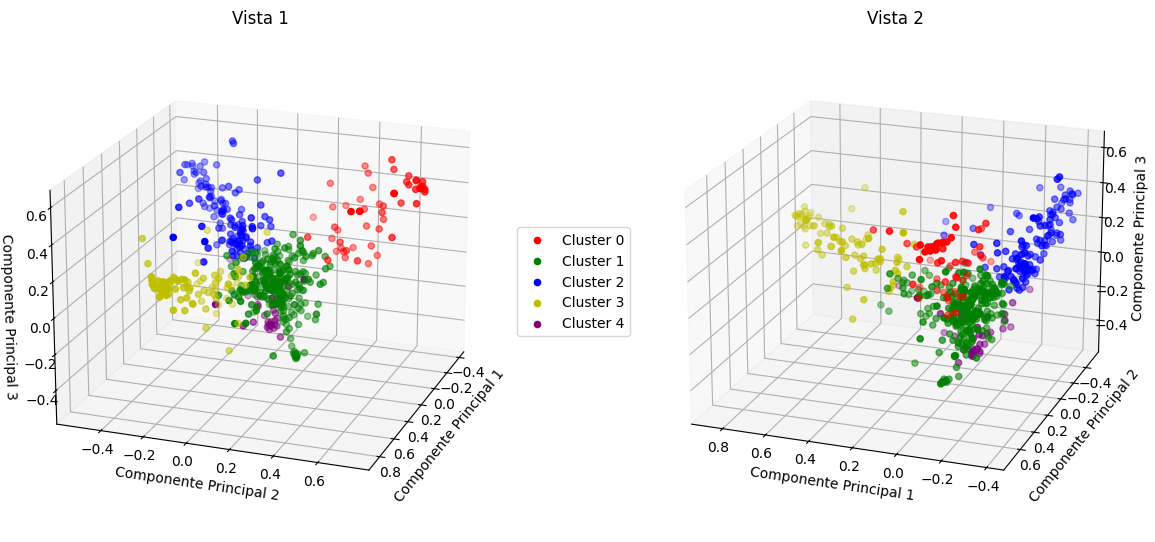

In [183]:
# Crear la figura
fig = plt.figure(figsize=(18, 6))

# Lista de perspectivas (elevación y azimut)
perspectives = [(20, 20), (20, 110)]

# Colores para los clusters
colors = ['r', 'g', 'b', 'y', 'purple']

# Graficar los datos y colorear por cluster desde diferentes perspectivas
for idx, (elev, azim) in enumerate(perspectives):
    ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
    for i in range(5):
        ax.scatter(X_3d[y_pred == i, 0], X_3d[y_pred == i, 1], X_3d[y_pred == i, 2], c=colors[i], label=f'Cluster {i}')
    
    # Añadir título y etiquetas
    ax.set_title(f'Vista {idx + 1}')
    ax.set_xlabel('Componente Principal 1', labelpad=-2)
    ax.tick_params(axis='x', pad=-2)
    ax.set_ylabel('Componente Principal 2', labelpad=-2)
    ax.tick_params(axis='y', pad=-2)
    ax.set_zlabel('Componente Principal 3', labelpad=-2)
    ax.tick_params(axis='z', pad=-2)

    # Cambiar perspectiva
    ax.view_init(elev=elev, azim=azim)

    # Añadir leyenda
    if idx == 0:  # Solo añadir leyenda en el primer subplot para evitar duplicados
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [172]:
loadings = pca_3d.components_
feature_names = df_pca.columns
loadings_df = pd.DataFrame(loadings.T, index=feature_names, columns=[f'PC{i+1}' for i in range(loadings.shape[0])])

In [173]:
loadings_df

,PC1,PC2,PC3
accent,-0.009757,-0.003143,-0.004863
actually,-0.002295,0.001408,-0.001808
afraid,0.000733,0.006249,-0.002428
afternoon,-0.008940,0.003278,0.002921
ah,-0.002555,0.005654,-0.000945
...,...,...,...
wow,-0.006180,0.003366,-0.004026
wrong,-0.008142,-0.000446,0.000581
ya,-0.010828,0.011708,-0.019253
yard,-0.011015,0.009650,0.012978


In [174]:
def plot_top_contributors(loadings_df, n=5):
    for col in loadings_df.columns:
        sorted_loadings = loadings_df[col].abs().sort_values(ascending=False)
        top_contributors = sorted_loadings.head(n)
        
        plt.figure(figsize=(10, 6))
        plt.bar(top_contributors.index, top_contributors.values, color='skyblue')
        plt.title(f'Principales {n} contribuyentes para {col}')
        plt.xlabel('Característica')
        plt.ylabel('Carga Absoluta')
        plt.xticks(rotation=45)
        plt.show()


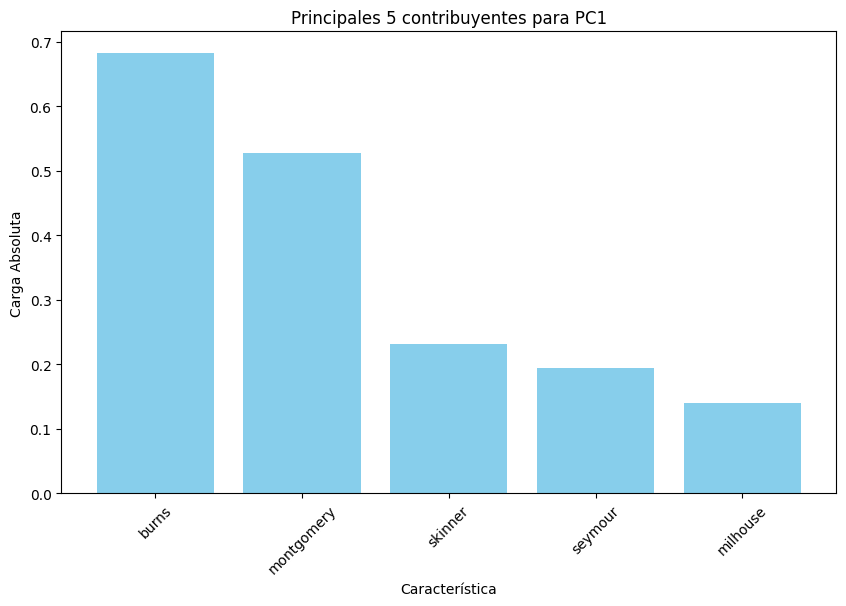

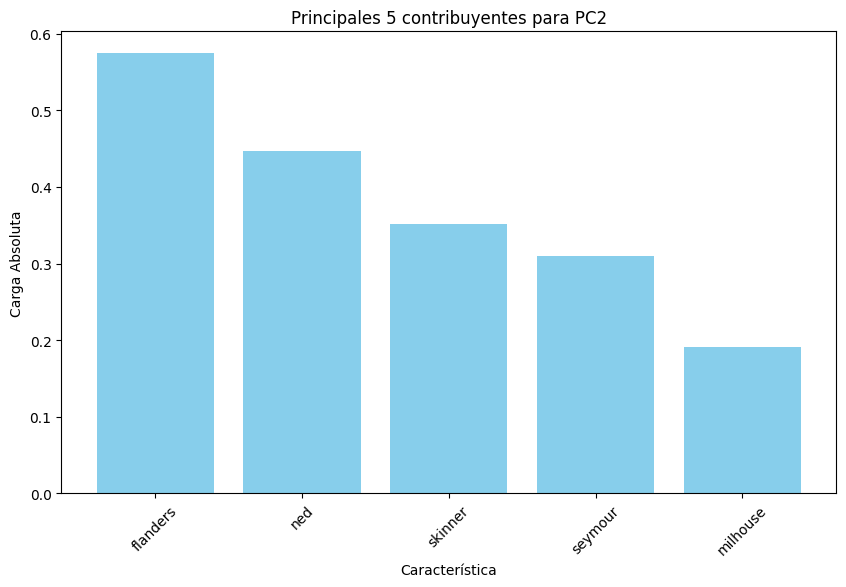

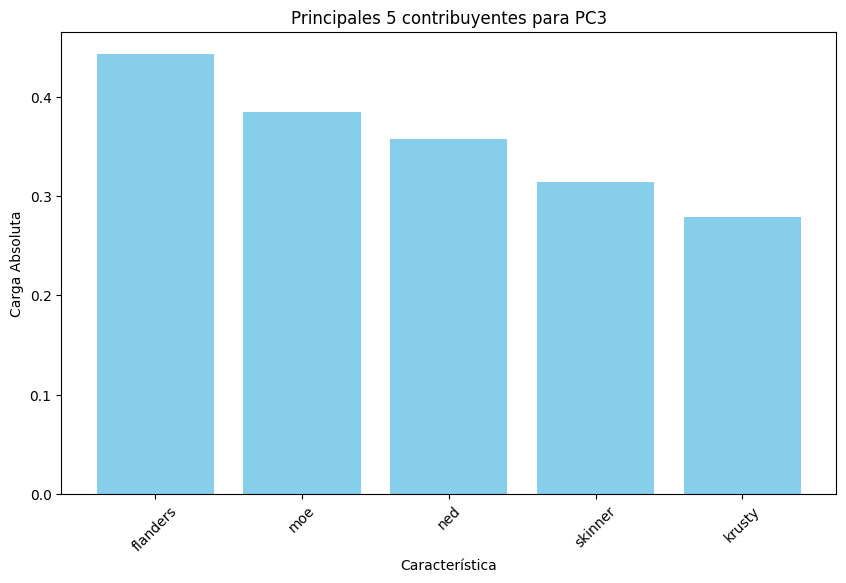

In [175]:
plot_top_contributors(loadings_df, n=5)


/var/folders/wr/llsqfgn14y9g_c3l32fq8qxw0000gn/T/ipykernel_22652/1847605970.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_components)


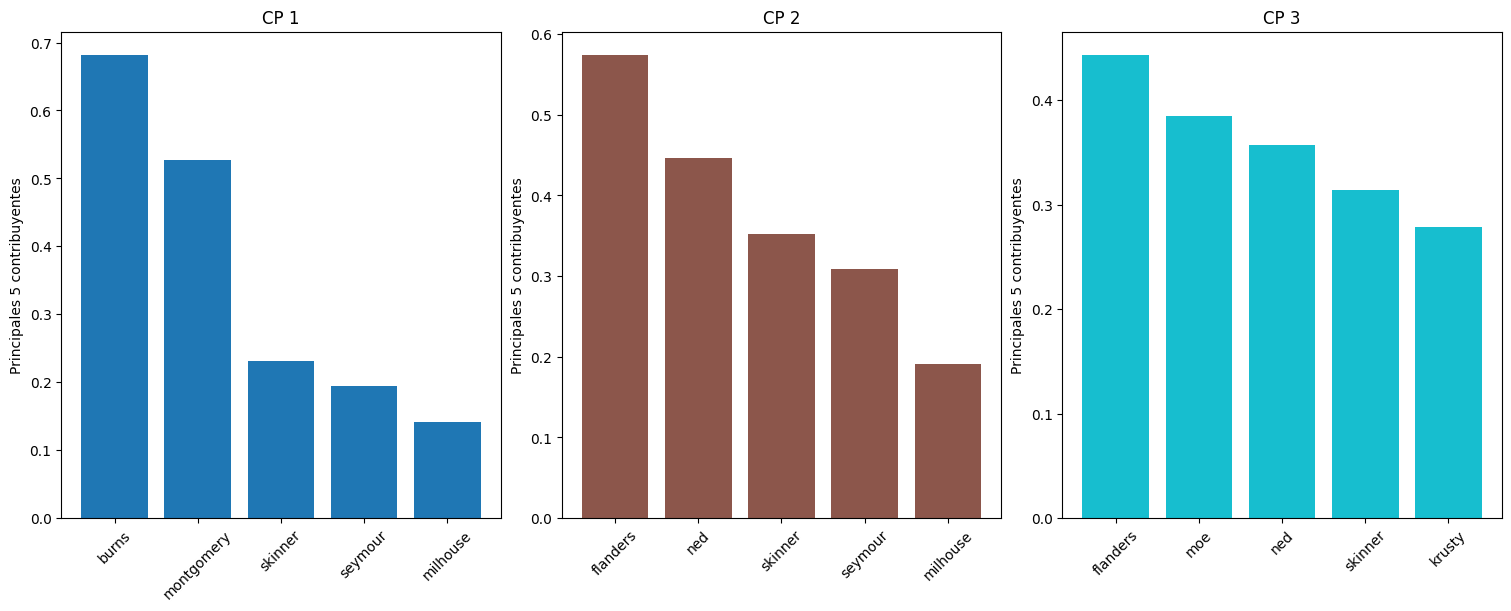

In [181]:
def plot_top_contributors(loadings_df, n=5):
    num_components = len(loadings_df.columns)
    colors = plt.cm.get_cmap('tab10', num_components)

    fig, axes = plt.subplots(1, num_components, figsize=(num_components * 5, 6), constrained_layout=True)

    for idx, col in enumerate(loadings_df.columns):
        sorted_loadings = loadings_df[col].abs().sort_values(ascending=False)
        top_contributors = sorted_loadings.head(n)
        
        ax = axes[idx] if num_components > 1 else axes
        ax.bar(top_contributors.index, top_contributors.values, color=colors(idx))
        ax.set_title(f'CP {idx+1}')
        ax.set_ylabel(f'Principales {n} contribuyentes')
        ax.set_xticks(range(len(top_contributors.index)))
        ax.set_xticklabels(top_contributors.index, rotation=45)

    plt.show()


plot_top_contributors(loadings_df, n=5)
